In [ ]:
!python -m pip install pyyaml==5.1 -q
import sys, os, distutils.core

# Clonar o repositório detectron2 e sidewalk-depthanything
!git clone 'https://github.com/facebookresearch/detectron2' -q
!git clone 'https://github.com/vini-castro/sidewalk_depthanything' -q

# Instalar dependências do detectron2
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} -q

# Adicionar detectron2 ao sys.path
sys.path.insert(0, os.path.abspath('./detectron2'))


# Imprimir versões de torch e detectron2
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.
fatal: destination path 'sidewalk_depthanything' already exists and is not an empty directory.


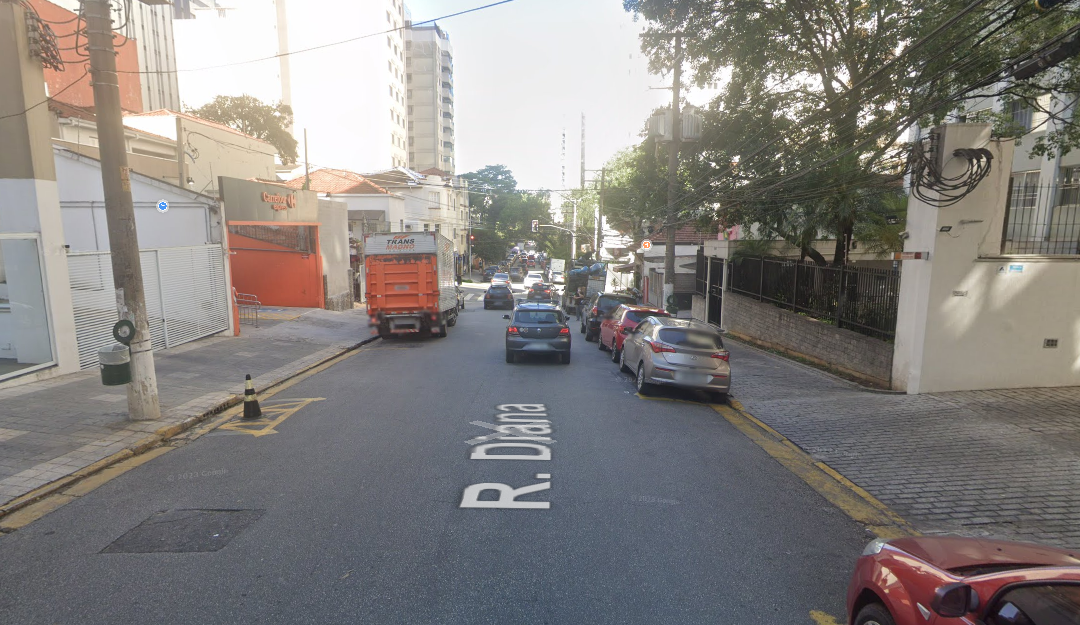

In [ ]:
#Coloque o nome da foto.
#Para usar uma foto personalizada, importe ela para a pasta assets/examples, e mude o formato, caso necessário
foto = 'Foto5'
im = cv2.imread(f"./sidewalk_depthanything/assets/examples/{foto}.png")
cv2_imshow(im)

In [ ]:
#Tem que ser rodado depois que completar o run
im_depth = cv2.imread(f"./sidewalk_depthanything/depth_vis/{foto}_img_depth.png")
cv2_imshow(im_depth)

AttributeError: 'NoneType' object has no attribute 'clip'

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

[04/25 02:24:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /root/.torch/iopath_cache/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...
INFO:fvcore.common.checkpoint:Reading a file from 'Detectron2 Model Zoo'


tensor([[22, 22, 22,  ..., 18, 18, 18],
        [22, 22, 22,  ..., 18, 18, 18],
        [22, 22, 22,  ..., 18, 18, 18],
        ...,
        [17, 17, 17,  ...,  0,  0,  0],
        [17, 17, 17,  ...,  0,  0,  0],
        [17, 17, 17,  ...,  0,  0,  0]], dtype=torch.int32)
[{'id': 1, 'isthing': True, 'score': 0.9951688647270203, 'category_id': 2, 'instance_id': 0}, {'id': 2, 'isthing': True, 'score': 0.9943206310272217, 'category_id': 2, 'instance_id': 1}, {'id': 3, 'isthing': True, 'score': 0.9850499033927917, 'category_id': 2, 'instance_id': 2}, {'id': 4, 'isthing': True, 'score': 0.9826434254646301, 'category_id': 2, 'instance_id': 3}, {'id': 5, 'isthing': True, 'score': 0.9681039452552795, 'category_id': 2, 'instance_id': 4}, {'id': 6, 'isthing': True, 'score': 0.9597371220588684, 'category_id': 2, 'instance_id': 5}, {'id': 7, 'isthing': True, 'score': 0.9549112319946289, 'category_id': 7, 'instance_id': 6}, {'id': 8, 'isthing': True, 'score': 0.9519096612930298, 'category_id': 2, '

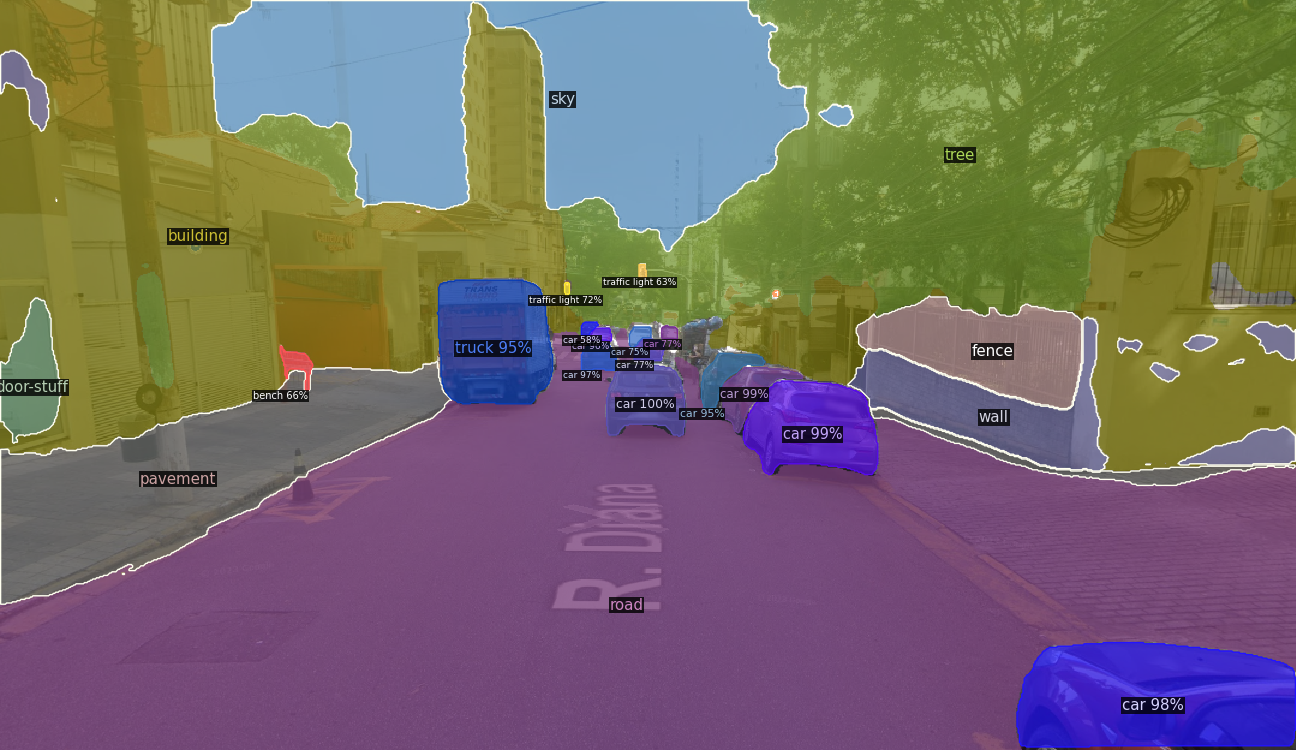

In [ ]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
print(panoptic_seg)
print(segments_info)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

for item in segments_info:
    if item['category_id'] == 44:
        id_calcada = item['id']

In [ ]:
print(panoptic_seg.shape)
print(id_calcada)

torch.Size([591, 1123])
18


In [ ]:
%cd sidewalk_depthanything/

/content/sidewalk_depthanything/sidewalk_depthanything/sidewalk_depthanything/sidewalk_depthanything


In [ ]:
import argparse
import cv2
import numpy as np
import os
import torch
import torch.nn.functional as F

from sidewalk_depthanything.pixel_size import pixel_sum
from torchvision.transforms import Compose
from tqdm import tqdm
from sidewalk_depthanything.depth_anything.dpt import DepthAnything
from sidewalk_depthanything.depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

import sys
for idx, arg in enumerate(sys.argv):
    if arg == '-f':
        sys.argv.pop(idx)
        sys.argv.pop(idx)

parser = argparse.ArgumentParser(allow_abbrev=False)
parser.add_argument('--img-path', type=str, default=f'assets/examples/{foto}.png')
parser.add_argument('--outdir', type=str, default='depth_vis')
parser.add_argument('--encoder', type=str, default='vitl', choices=['vits', 'vitb', 'vitl'])
parser.add_argument('--pred-only', dest='pred_only', action='store_true', help='only display the prediction')
parser.add_argument('--grayscale', dest='grayscale', action='store_true', help='do not apply colorful palette')
args = parser.parse_args()

margin_width = 50
caption_height = 60

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_thickness = 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(args.encoder)
depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{}14'.format(args.encoder)).to(DEVICE).eval()

total_params = sum(param.numel() for param in depth_anything.parameters())
print('Total parameters: {:.2f}M'.format(total_params / 1e6))

transform = Compose([
  Resize(
      width=518,
      height=518,
      resize_target=False,
      keep_aspect_ratio=True,
      ensure_multiple_of=14,
      resize_method='lower_bound',
      image_interpolation_method=cv2.INTER_CUBIC,
  ),
  NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  PrepareForNet(),
])

focal_length = 5

if os.path.isfile(args.img_path):
  if args.img_path.endswith('txt'):
      with open(args.img_path, 'r') as f:
          filenames = f.read().splitlines()
  else:
      filenames = [args.img_path]
else:
  filenames = os.listdir(args.img_path)
  filenames = [os.path.join(args.img_path, filename) for filename in filenames if not filename.startswith('.')]
  filenames.sort()

os.makedirs(args.outdir, exist_ok=True)

for filename in tqdm(filenames):
  raw_image = cv2.imread(filename)
  image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0

  h, w = image.shape[:2]

  image = transform({'image': image})['image']
  image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)

  with torch.no_grad():
      depth = depth_anything(image)

  depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
  depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0

  depth = depth.cpu().numpy().astype(np.uint8)

  physical_depth = focal_length / depth.astype(np.float32)

  object_width_pixels = 100
  object_width_cm = object_width_pixels * physical_depth / focal_length

  np.set_printoptions(threshold=np.inf, linewidth=np.inf)

  if args.grayscale:
      depth = np.repeat(depth[..., np.newaxis], 3, axis=-1)
  else:
      depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)

  filename = os.path.basename(filename)

  if args.pred_only:
      cv2.imwrite(os.path.join(args.outdir, filename[:filename.rfind('.')] + '_depth.png'), depth)
  else:
      split_region = np.ones((raw_image.shape[0], margin_width, 3), dtype=np.uint8) * 255
      combined_results = cv2.hconcat([raw_image, split_region, depth])

      caption_space = np.ones((caption_height, combined_results.shape[1], 3), dtype=np.uint8) * 255
      captions = ['Raw image', 'Depth Anything']
      segment_width = w + margin_width

      for i, caption in enumerate(captions):
          text_size = cv2.getTextSize(caption, font, font_scale, font_thickness)[0]

          text_x = int((segment_width * i) + (w - text_size[0]) / 2)

          cv2.putText(caption_space, caption, (text_x, 40), font, font_scale, (0, 0, 0), font_thickness)

      final_result = cv2.vconcat([caption_space, combined_results])

      cv2.imwrite(os.path.join(args.outdir, filename[:filename.rfind('.')] + '_img_depth.png'), final_result)
  sum_first_row = np.sum(object_width_cm[0])

  # print("Primeiro vetor:", str(object_width_cm[0]))
  # print("Largura estimada do objeto em cm:", object_width_cm)
  # print("Distancia do começo ao final da imagem:" + str(pixel_sum(object_width_cm[200])))


vitl


INFO:dinov2:using MLP layer as FFN


Total parameters: 335.32M


  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-50-09e5e72f7080>:89: RuntimeWarning: divide by zero encountered in divide
  physical_depth = focal_length / depth.astype(np.float32)
100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


In [ ]:
mask = panoptic_seg == id_calcada

area = np.sum(np.square(object_width_cm)[mask])

print(f"Área útil da calçada: {area/10000:.2f} m^2")

Área útil da calçada: 232.69 m^2


In [ ]:
#Calculo da calçada da direita
import numpy as np

distancias_direita = []
distancias_esquerda = []

meio = panoptic_seg.shape[0] // 2

print("======DIREITA=====")
for j in range(int(panoptic_seg.shape[:][0]/3), panoptic_seg.shape[:][0]):
    linha = panoptic_seg[j, :]
    inicio = meio + np.argmax(linha[meio:] == id_calcada)

    soma = 0
    for i in range(meio, len(linha) - 1):
        if linha[i] == id_calcada:
            soma += object_width_cm[j][i]

    print(f"Tamanho da calçada horizontal na linha {j}: {soma}")

    if soma != 0:
        distancias_direita.append(soma)

print("======ESQUERDA=====")
for j in range(int(panoptic_seg.shape[:][0]/3), panoptic_seg.shape[:][0]):
    linha = panoptic_seg[j, :]
    inicio = meio + np.argmax(linha[0:meio] == id_calcada)

    soma = 0
    for i in range(0, meio):
        if linha[i] == id_calcada:
            soma += object_width_cm[j][i]

    print(f"Tamanho da calçada horizontal na linha {j}: {soma}")

    if soma != 0:
        distancias_esquerda.append(soma)


======DIREITA=====
Tamanho da calçada horizontal na linha 208: 0
Tamanho da calçada horizontal na linha 209: 0
Tamanho da calçada horizontal na linha 210: 0
Tamanho da calçada horizontal na linha 211: 0
Tamanho da calçada horizontal na linha 212: 0
Tamanho da calçada horizontal na linha 213: 0
Tamanho da calçada horizontal na linha 214: 0
Tamanho da calçada horizontal na linha 215: 0
Tamanho da calçada horizontal na linha 216: 0
Tamanho da calçada horizontal na linha 217: 0
Tamanho da calçada horizontal na linha 218: 0
Tamanho da calçada horizontal na linha 219: 0
Tamanho da calçada horizontal na linha 220: 0
Tamanho da calçada horizontal na linha 221: 0
Tamanho da calçada horizontal na linha 222: 0
Tamanho da calçada horizontal na linha 223: 0
Tamanho da calçada horizontal na linha 224: 0
Tamanho da calçada horizontal na linha 225: 0
Tamanho da calçada horizontal na linha 226: 0
Tamanho da calçada horizontal na linha 227: 0
Tamanho da calçada horizontal na linha 228: 0
Tamanho da calç

In [ ]:
media_dir = np.mean(distancias_direita)
media_esq = np.mean(distancias_esquerda)
print("Média direita:", media_dir)
print("Média esquerda:", media_esq)
mediana_dir = np.median(distancias_direita)
mediana_esq = np.median(distancias_esquerda)
print("Mediana direita:", mediana_dir)
print("Mediana esquerda:", mediana_esq)

Média direita: 137.9961349700506
Média esquerda: 276.0544019681637
Mediana direita: 159.87987542152405
Mediana esquerda: 275.79935187101364
